In [40]:
import requests
import pandas as pd

In [41]:
# @title Download and store the dataset

# URL of the dataset text file on GitHub
text_file_url = 'https://raw.githubusercontent.com/Paco-Danes/DeepPoi/main/dataset_NYC.txt'

# The directory to store the file in the colab session
file_path = '/content/dataset/example_dataset.txt'

# Download the file
r = requests.get(text_file_url)

# Save the content to a file
with open(file_path, 'w') as f:
    f.write(r.text)

print("Text file downloaded and saved to:", file_path)

Text file downloaded and saved to: /content/dataset/example_dataset.txt


In [51]:
# Read the TSV file into a DataFrame
df = pd.read_csv(file_path, sep='\t')
# Column names
column_names = [
    'User_ID',
    'Venue_ID',
    'Venue_Category_ID',
    'Venue_Category_Name',
    'Latitude',
    'Longitude',
    'Timezone_Offset',
    'UTC_Time'
]
# Assign column names to the DataFrame
df.columns = column_names
# Shape check of the DataFrame
df.shape

(227427, 8)

In [60]:
df.head()

,User_ID,Venue_ID,Venue_Category_ID,Venue_Category_Name,Latitude,Longitude,Timezone_Offset,UTC_Time
0,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
1,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
2,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
3,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012
4,484,4b5b981bf964a520900929e3,4bf58dd8d48988d118951735,Food & Drink Shop,40.690427,-73.954687,-240,Tue Apr 03 18:04:00 +0000 2012


In [82]:
len(df[df['User_ID'] == 484]['Venue_ID'].unique())

146

In [71]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00


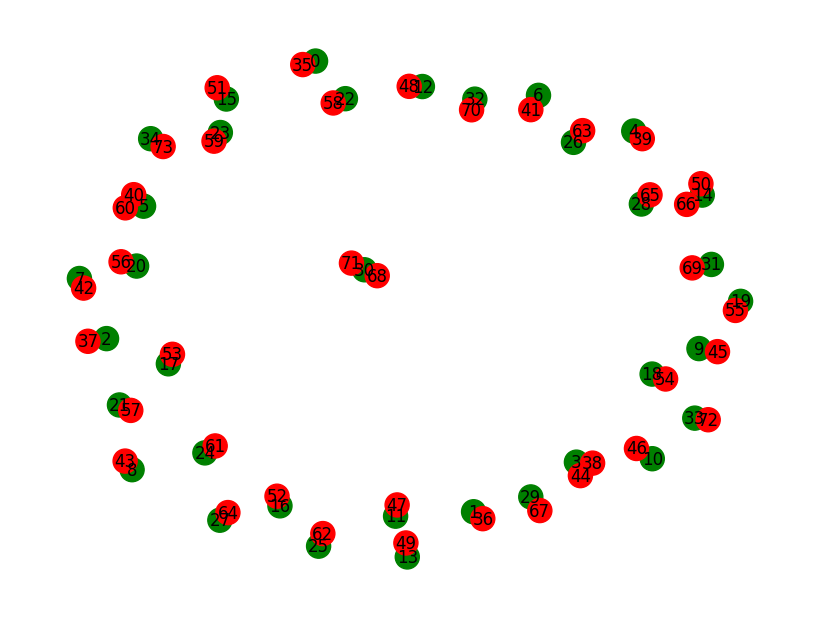

In [94]:
import torch
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv('/content/example_dataset.txt', sep='\t', encoding='utf-8')
df_sample = df.head(40)  # Take the first 25 rows for simplicity

# Mapping for user and POI IDs to sequential indices
user_id_mapping = {uid: idx for idx, uid in enumerate(df_sample['User_ID'].unique())}
poi_id_mapping = {pid: idx for idx, pid in enumerate(df_sample['Venue_ID'].unique())}

# Create edge indices and edge weights
edge_indices = []
edge_weights = []

# Iterate over DataFrame rows to create edges
for _, row in df_sample.iterrows():
    user_index = user_id_mapping[row['User_ID']]
    poi_index = len(user_id_mapping) + poi_id_mapping[row['Venue_ID']]
    edge_indices.append([user_index, poi_index])
    edge_weights.append(1)  # Assuming equal weight for each edge

# Convert edge indices and edge weights to tensors
edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
edge_weights = torch.tensor(edge_weights, dtype=torch.float)

# Create node features for users and POIs
num_users = len(user_id_mapping)
num_pois = len(poi_id_mapping)
user_features = torch.tensor([[1.0] for _ in range(num_users)], dtype=torch.float)  # Example feature for users
poi_features = torch.tensor([[1.0] for _ in range(num_pois)], dtype=torch.float)    # Example feature for POIs

# Create PyG Data object
data = Data(x=torch.cat([user_features, poi_features], dim=0),  # Concatenate user and POI features
            edge_index=edge_indices,
            edge_attr=edge_weights,
            num_nodes=num_users + num_pois)

# Convert PyG Data object to NetworkX graph
graph = nx.Graph()
graph.add_nodes_from(range(num_users), node_type='user')
graph.add_nodes_from(range(num_users, num_users + num_pois), node_type='poi')
graph.add_edges_from(edge_indices.t().numpy())  # Transpose for correct edge format

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(graph)
colors = ['g'] * num_users + ['r'] * num_pois
nx.draw(graph, pos, node_color=colors, with_labels=True)
plt.show()
